<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

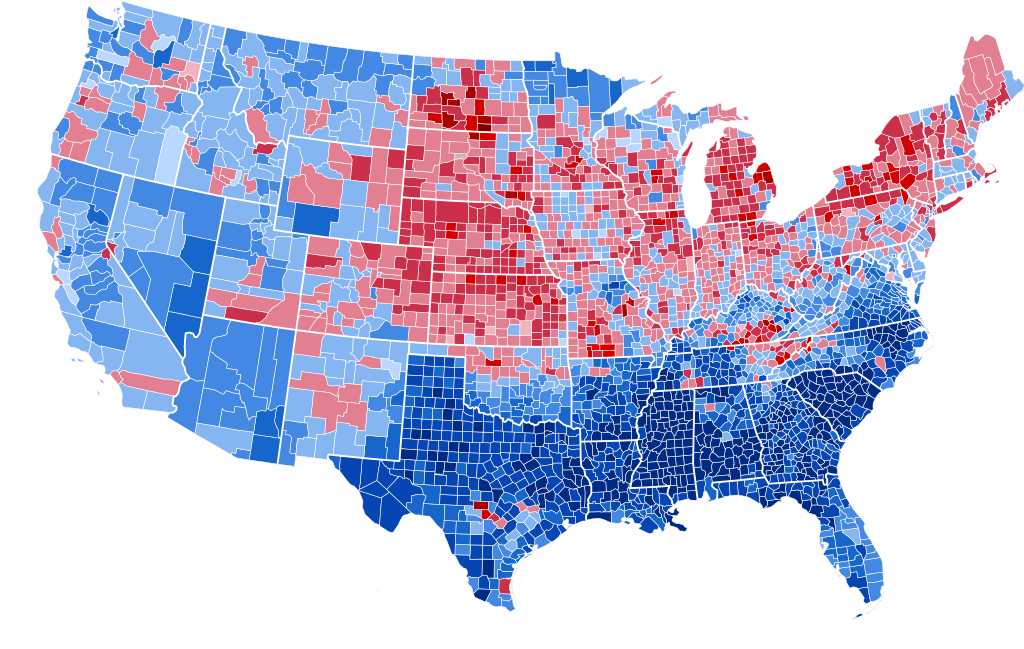

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Split train and validation sets of the train data
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings # Remove Warning print statements
warnings.filterwarnings('ignore') # Ignore 

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [10]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [11]:
# Preprocessing any train dataframe (2016/2012 train)
def preprocess(df):    
    '''Preprocesses the training data  
    Args: 
     df: input dataframe
    Returns: 
      df with a Winner indicator column and normalized feature columns
    '''
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
   
    # Max normalization - Divide by the largest absolute valued feature value
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col]/factor
    return df

# Preprocessing any test dataframe (2016/2012 test)
def test_preprocess(df):
    '''Preprocesses the training data  
    Args: 
     df: input dataframe
    Returns: 
      df with normalized feature columns
    '''
    # Max normalization - Divide by the largest absolute valued feature value
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col]/factor
    return df

# Package a list of predictions for submission
def package(preds, df):
    '''Packages the predictions for submission using the sample data frame
    Args: 
     preds: input list of predictions
     df: sample dataframe
    Returns: 
      df with predictions substituted in for sample predictions
    '''
    df['Result'][0:] = preds.astype(int)
    return df

In [12]:
# Preprocess training 2016 dataset (keep original intact and unchanged)
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.045287,0.439863,0.384615,0.280161,0.174274,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.170055,0.316151,0.220280,0.160858,0.286307,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.012015,0.391753,0.409091,0.202413,0.219917,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.085028,0.487973,0.174825,0.537534,0.120332,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.118299,0.336770,0.185315,0.089812,0.580913,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.032348,0.384880,0.377622,0.256032,0.248963,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.024030,0.336770,0.356643,0.321716,0.215768,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.014787,0.347079,0.363636,0.195710,0.269710,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.085028,0.443299,0.454545,0.261394,0.190871,0


In [13]:
# Preprocess training 2012 dataset (keep original intact and unchanged)
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",20775,25422,0.413372,0.000832,0.458042,0.431111,0.273611,0.284672,0
1,6035,"Lassen County, CA",3044,7261,0.399213,-0.164725,0.314685,0.355556,0.179167,0.456204,0
2,40081,"Lincoln County, OK",3265,9542,0.371206,-0.023295,0.395105,0.493333,0.181944,0.182482,0
3,31153,"Sarpy County, NE",24709,40318,0.572738,0.066556,0.555944,0.217778,0.508333,0.142336,0
4,28055,"Issaquena County, MS",479,302,0.242874,0.018303,0.300699,0.320000,0.108333,0.642336,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",11695,15406,0.360048,-0.062396,0.409091,0.448889,0.250000,0.339416,0
1551,55031,"Douglas County, WI",14855,7698,0.366363,-0.054077,0.384615,0.404444,0.304167,0.251825,1
1552,27065,"Kanabec County, MN",3586,4319,0.371879,-0.122296,0.248252,0.364444,0.186111,0.328467,0
1553,17139,"Moultrie County, IL",2142,3781,0.427624,0.006656,0.430070,0.528889,0.215278,0.259124,0


In [14]:
# Read in graph data
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph

,SRC,DST
0,1001,1001
1,1001,1021
2,1001,1047
3,1001,1051
4,1001,1085
...,...,...
12712,72153,72153
12713,78010,78010
12714,78020,78020
12715,78020,78030


In [15]:
# Read in Sample dataframe
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

,FIPS,Result
0,17059,0
1,6103,0
2,42047,0
3,47147,0
4,39039,0
...,...,...
1550,55095,0
1551,34035,0
1552,42107,0
1553,48293,0


In [16]:
# Preprocess testing 2016 dataset (keep original intact and unchanged)
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.335782,-0.050548,0.378947,0.363372,0.126115,0.381910
1,6103,"Tehama County, CA",0.343839,0.008584,0.449123,0.302326,0.197452,0.356784
2,42047,"Elk County, PA",0.417452,-0.044349,0.340351,0.377907,0.236943,0.276382
3,47147,"Robertson County, TN",0.495506,0.035289,0.445614,0.281977,0.236943,0.206030
4,39039,"Defiance County, OH",0.442326,-0.025274,0.389474,0.296512,0.212739,0.246231
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.454619,0.006676,0.333333,0.313953,0.259873,0.231156
1551,34035,"Somerset County, NJ",0.886754,-0.009061,0.354386,0.209302,0.694268,0.206030
1552,42107,"Schuylkill County, PA",0.426136,-0.000477,0.326316,0.389535,0.206369,0.311558
1553,48293,"Limestone County, TX",0.333647,0.002384,0.463158,0.328488,0.178344,0.281407


In [17]:
# Preprocess testing 2012 dataset (keep original intact and unchanged)
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.314441,-0.128660,0.299003,0.570796,0.142477,0.351464
1,6103,"Tehama County, CA",0.318161,-0.031056,0.378738,0.420354,0.187750,0.573222
2,42047,"Elk County, PA",0.401674,-0.026619,0.322259,0.548673,0.205060,0.292887
3,47147,"Robertson County, TN",0.445897,-0.039929,0.475083,0.415929,0.225033,0.292887
4,39039,"Defiance County, OH",0.382532,-0.057675,0.385382,0.433628,0.217044,0.322176
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.412586,-0.099379,0.318937,0.371681,0.255659,0.334728
1551,34035,"Somerset County, NJ",0.788239,0.000000,0.345515,0.300885,0.692410,0.309623
1552,42107,"Schuylkill County, PA",0.366433,0.007098,0.328904,0.584071,0.198402,0.405858
1553,48293,"Limestone County, TX",0.300998,0.011535,0.451827,0.469027,0.181092,0.288703


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [18]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search the hyperparameters
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            # 10-Fold Cross validation via Sklearn
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [19]:
# Basic Model 2 - SVM. 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search the hyperparameters
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            # 10-Fold Cross validation via Sklearn
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [20]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [21]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

# Cross-validate on hyperparameters for model selection
best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8309138534813879, 4, 'minkowski']


In [22]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

# Cross-validate on hyperparameters for model selection
best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

KeyboardInterrupt: 

In [15]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)


# Check number of DEM and GOP counties predicted for further validation information
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
series_knn = submiss_knn['Result'].value_counts()
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')
series_svm = submiss_svm['Result'].value_counts()

print(series_knn) 
print(series_svm)

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

#### 2.4.1 How did you preprocess the dataset and features?

For the basic section we kept things simple and only used the primary 6 features given to us. All we did was normalized these features all by dividing by the absolute max value. We also tried more standard techniques such as min/max as well as standardization normalization techniques as shown in class but neither worked as well as just normal “max” normalization when we fed the data into our basic models  (SVM, KNN) for validation. This could be due to information loss with some feature columns having negative values prior to normalization that no longer have negative values post normalization. Aside from that, we created a target column that consisted of labeling whether a county had more DEM or GOP votes as specified in the handout.

#### 2.4.2 Which two learning methods from class did you choose and why did you made the choices?

We chose the K-Nearest Neighbors and Support Vector Machines learning methods. 

We first used **K-Nearest Neighbors** due to its simplicity and ease of use for empirical risk minimization, as well as the fact that we expect data points in the test set with similar features to have similar labels. Due to the KNN algorithm, it inherently assigns the same label to features with respect to its k neighbors according to some distance metric. The dataset is also relatively small, so the algorithm will not be bogged down by too much inefficiency. Also, the feature dimensionality is not so large, so the algorithm will not suffer from the “curse of dimensionality”.

We also used the **SVM**, specifically with the Radial Basis Function (RBF) kernel as our second basic model, because we expect our data to be nonlinearly separable, and a simple linear classifier would just not cut it. The RBF kernel is specifically used as it relates close points to likely have the same label, with a similar rationale to the use of KNN. By using a kernel to find a hyperplane within this kernel space to separate the data into classes, we can cross validate if needed on the SVM’s hyperparameters and choose the right model from our cross-validation.


#### 2.4.3 How did you do the model selection?

We performed model selection through a grid search on hyperparameters for both of the learning methods. For the KNN, this was done through passing a range of numbers for the value of `k` as well as the distance function for use in the algorithm. For this distance function, we consulted a paper “Effects of Distance Measure Choice on KNN Classifier Performance” by Prasath et al. [1], which suggested a few distance metrics included with scikit-learn that outperformed others in a study. 

For the SVM, this was done through passing evenly (power and linearly) spaced numbers through a specified interval using NumPy for each of the values of the hyperparameters we were evaluating, `C` and `gamma`. We consulted the scikit-learn documentation for these parameters to find typical values to use [2]. As for the actual cross-validation, we made use of `sklearn`’s `model_selection` package and specifically the `cross_val_score` on 10 folds, taking the mean of the scores on each of these partitions and caching the best-performing model to be selected for use on the test data. We decided on 10 folds as it doesn't take up too much time to compute results but also trains on 90% of the data available in each fold, making it a close approximation to training on all 100% of the data as we do before predicting on the test data. 


#### 2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](kaggle_submission_basic.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

### 3.1.1 Import Statements

In [23]:
#Basic + Tensorflow imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
import logging
tf.get_logger().setLevel(logging.ERROR) # suppress TF warnings from being printed
tf.random.set_seed(123)
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from IPython.display import clear_output


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [24]:
def gen_class_weights(df):
    '''
    Generate class weights
    '''
    df['Weight'] = 0.0
    # rationale: training data has roughly 5.9 ratio of GOP counties to DEM
    d_weight = 5.0 
    r_weight = 1.0
    # assign weights accordingly
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight  
    return df

def gen_labels(df):
    '''
    Binary Indicator of Dem or GOP winner of a county
    '''
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0 
    return df

def norm_preprocess(df):
    '''
    Max normalization - Divide by the largest absolute valued feature value

    '''
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col] / factor
    return df

def ratio_preprocess(df):
    '''
    NOT USED
    
    Generate labels that are the ratio of dem voters to total voters
    '''
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] = mult * d / total_pop
    return df

def cthresh(preds, thresh = 0.5):
    '''
    Threshold a set of predictions based on the threshold
    '''
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    '''
    Threshold a set of predictions as a dataframe, based on the threshold
    '''
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [25]:
# Re-read train/test data from given CSVs and preprocess the test data
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = gen_labels(rawdf16)
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = gen_labels(rawdf12)
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [26]:
def graph_process(d16, graph, result, result12):
    '''
    Preprocesses the given basic preprocessed dataframe (train or test) and extracts features from the graph data
    adds them to the dataframe
    Args: 
      d16: some preprocessed 2016 dataframe (train or test)
      graph: graph dataframe
      result: 2016 preprocessed dataframe with election results in a column
      result12: 2012 preprocessed dataframe with election results from 2012 in a column
    Returns: 
    Dataframe with graph data extracted into columns
    '''
    # Adds extra features to the dataframe based on the graph structure of counties
    # Note: Graph DST for each SRC is sorted least to greatest, other neighbors < DST FIPS can occur but with that DST as SRC
    neigh_exist, neigh_vote, neigh_swing, neigh_pop = [], [], [], []
    for row in range(len(d16)):
        # Get neighboring counties for this particular SRC
        neighbors = np.array(dfgraph[dfgraph['SRC'] == d16['FIPS'][row]]['DST'][1:])
        # Get neighboring counties that have this SRC as a DST
        neighbors = np.append(neighbors,np.array(dfgraph[dfgraph['DST'] == d16['FIPS'][row]]['SRC'][:-1]))
        prop, swing = [], []
        dem, gop = 0, 0
        for neigh in neighbors:
            if len(result[result['FIPS'] == neigh]) > 0:
                # Compute the proportion of neighbor counties that voted DEM
                prop = np.append(prop, np.array(result[result['FIPS'] == neigh]['Winner']))
                # Compute proportion of neighbors that swung from 2012 -> 2016                
                swing = np.append(swing, np.array(np.abs(np.array(result[result['FIPS'] == neigh]['Winner'])[0] - np.array(result12[result12['FIPS'] == neigh]['Winner'])[0])))
                # Add number of DEM votes in neighbors
                dem += np.array(result[result['FIPS'] == neigh]['DEM'])[0]
                # Add number of GOP votes in neighbors
                gop += np.array(result[result['FIPS'] == neigh]['GOP'])[0]
        if len(prop) == 0:
            # If no neighbors could be found in 2016, assign a feature value of 0 to represent it and 0.5 everything else
            neigh_vote.append(0.5)
            neigh_exist.append(0)
            neigh_swing.append(0.5)
            neigh_pop.append(0.5)
        else:
            # Append previously found values
            neigh_vote.append(np.mean(prop))
            neigh_exist.append(1)
            neigh_swing.append(np.mean(swing))
            # Append proportion of DEM voters in neighbors
            neigh_pop.append(dem / (dem + gop))

    # Add feature columns to training data
    d16['neigh_vote'] = np.array(neigh_vote)
    d16['neigh_exist'] = np.array(neigh_exist)
    d16['neigh_swing'] = np.array(neigh_swing)
    d16['neigh_pop'] = np.array(neigh_pop)
    return d16

In [27]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    '''
    Preprocesses the given basic preprocessed dataframe (train or test) and extracts features from the 2012 data
    adds them to the dataframe in addition to some other creative features such as one-hot encoding state markers
    Args: 
      d16: some preprocessed 2016 dataframe (train or test)
      d12: some preprocessed 2012 dataframe (train or test)      
      graph: graph dataframe
      test: boolean of whether or not d16 and d12 are test dataframes
    Returns: 
    Dataframe with creative features and preprocessing
    '''
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())
    # Add graph features
    creative = graph_process(creative.copy(), graph.copy(), df16.copy(), df12.copy())
    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    # A column with values of all state abbreviations 
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    
    # GENERATE 2012 COLS
    for cols in norm_cols:
        delta = np.array(d12[cols])
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
    
    # GENERATE DIFF COLS
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENERATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative

traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
neigh_vote              float64
neigh_exist               int64
neigh_swing             float64
neigh_pop               float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,...,BachelorRate2012,UnemploymentRate2012,MedianIncomeDiff,MigraRateDiff,BirthRateDiff,DeathRateDiff,BachelorRateDiff,UnemploymentRateDiff,Weight,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.045287,0.439863,0.384615,0.280161,0.174274,...,0.273611,0.284672,0.116587,0.073282,-0.032967,0.110169,0.063492,-0.734694,1.0,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.170055,0.316151,0.220280,0.160858,0.286307,...,0.179167,0.456204,0.100885,0.021374,0.021978,-0.144068,-0.047619,-1.142857,1.0,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.012015,0.391753,0.409091,0.202413,0.219917,...,0.181944,0.182482,0.033367,0.022901,0.010989,0.050847,0.105820,0.061224,1.0,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.085028,0.487973,0.174825,0.537534,0.120332,...,0.508333,0.142336,0.272866,0.018321,-0.186813,0.008475,0.185185,-0.204082,1.0,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.118299,0.336770,0.185315,0.089812,0.580913,...,0.108333,0.642336,-0.084137,-0.229008,0.131868,-0.161017,-0.058201,-0.734694,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.032348,0.384880,0.377622,0.256032,0.248963,...,0.250000,0.339416,0.148384,0.061069,-0.054945,0.059322,0.058201,-0.673469,1.0,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.024030,0.336770,0.356643,0.321716,0.215768,...,0.304167,0.251825,0.295154,0.059542,-0.131868,0.093220,0.111111,-0.346939,5.0,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.014787,0.347079,0.363636,0.195710,0.269710,...,0.186111,0.328467,0.310464,0.248855,0.329670,0.186441,0.063492,-0.510204,1.0,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.085028,0.443299,0.454545,0.261394,0.190871,...,0.215278,0.259124,0.287347,-0.152672,0.065934,0.093220,0.211640,-0.510204,1.0,0


### 3.2 Choose Data Being Sent To Model


In [57]:
print(tf.__version__)

# Trim unique identifier labels
trimmed_data_frame = traindf.iloc[0:,4:]

# Define sets of training data to use for the model
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []
NUMERIC_GRAPH_EXTEND = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]
NUMERIC_GRAPH_EXTEND = ['neigh_vote', 'neigh_swing', 'neigh_pop']

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# We are not using Diff since we found it negatively affected performance
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF 
NUMERIC_COLUMNS += NUMERIC_GRAPH_EXTEND

# Handy block of code that lets us remove columns at will
REMOVE = ['MigraRate', 'MigraRate2012', 'BirthRate']
NUMERIC_COLUMNS = [x for x in NUMERIC_COLUMNS if x not in REMOVE]

2.3.1


### 3.3 Define Model Helper Functions


In [58]:
# Model util functions
def one_hot_cat_column(feature_name, vocab):
    '''
    From tensorflow tutorial: One hot encoder helper function
    '''
    return tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    '''
    From tensorflow tutorial: wrap data for training, or for validation
    '''
    NUM_EXAMPLES = len(y)
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

def generate_mini_batch(entire_data_frame, num_rows):
    '''
    Generate a training and validation mini batch from entire_data_frame
    
    Both batches haave size num_rows
    '''
    local_copy = entire_data_frame.copy()
    subdf = local_copy.sample(n = num_rows*2, replace = False)

    # Winner is in last col
    label_idx = len(subdf.columns) - 1

    sub_x = subdf.iloc[0:,:label_idx]
    sub_y = subdf.iloc[0:,label_idx]
    
    split = num_rows
    
    valid_x = sub_x.iloc[split:,:]
    valid_y = sub_y.iloc[split:]    
    sub_x = sub_x.iloc[:split,:]
    sub_y = sub_y.iloc[:split]
    
    return sub_x, sub_y, valid_x, valid_y

def info_weighted_accuracy(pred, true):
    '''
    Returns weighted accuracy, as well as statistics on raw errors.
    
    weighted_accuracy, democrat_error, republican_error,
    total_errors, number_labels
    '''
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    t_e = d_err+r_err
        
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy,d_err,r_err,t_e,num_labels

In [ ]:
### 3.3 Train the Model


[ *** ] STEP MAX: 50
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                 0.707711
accuracy_baseline        0.527363
auc                      0.827691
auc_precision_recall     0.786726
average_loss             0.572558
label/mean               0.472637
loss                     0.920673
precision                0.773585
prediction/mean          0.444018
recall                   0.539474
global_step             50.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 35; R ERR: 60 TOTAL ERR: 95 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.698982125124131
[ $ ] VALIDATION ACCURACY OVER TIME: 


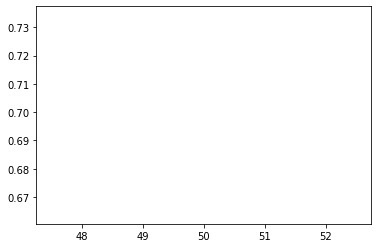

[ $$$ ] TEST


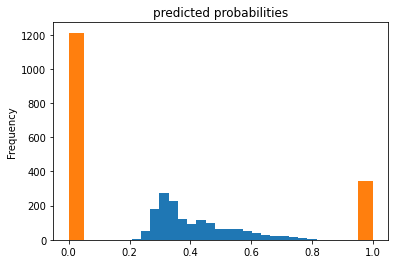

[ *** ] STEP MAX: 100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.798267
accuracy_baseline         0.523515
auc                       0.857281
auc_precision_recall      0.833214
average_loss              0.490604
label/mean                0.476485
loss                      0.792816
precision                 0.801630
prediction/mean           0.468645
recall                    0.766234
global_step             100.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 18; R ERR: 73 TOTAL ERR: 91 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7968284670412329
[ $ ] VALIDATION ACCURACY OVER TIME: 


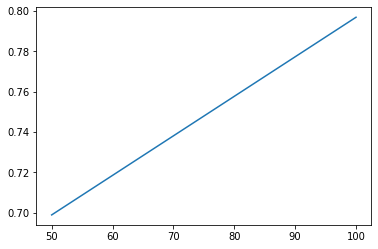

[ $$$ ] TEST


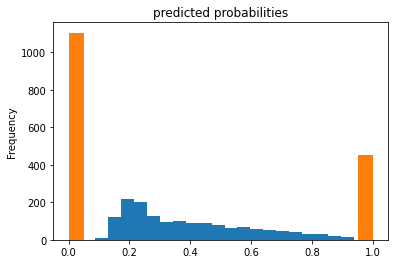

[ *** ] STEP MAX: 150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.782500
accuracy_baseline         0.531250
auc                       0.890635
auc_precision_recall      0.872044
average_loss              0.437235
label/mean                0.468750
loss                      0.699575
precision                 0.815047
prediction/mean           0.433946
recall                    0.693333
global_step             150.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 23; R ERR: 59 TOTAL ERR: 82 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7772549019607843
[ $ ] VALIDATION ACCURACY OVER TIME: 


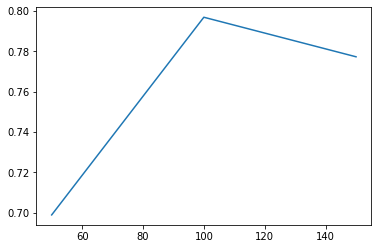

[ $$$ ] TEST


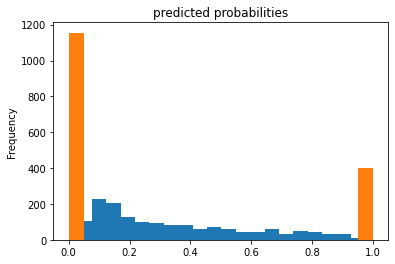

[ *** ] STEP MAX: 200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.753846
accuracy_baseline         0.551282
auc                       0.868040
auc_precision_recall      0.831973
average_loss              0.455791
label/mean                0.448718
loss                      0.711034
precision                 0.745342
prediction/mean           0.442618
recall                    0.685714
global_step             200.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 22; R ERR: 82 TOTAL ERR: 104 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7475083056478405
[ $ ] VALIDATION ACCURACY OVER TIME: 


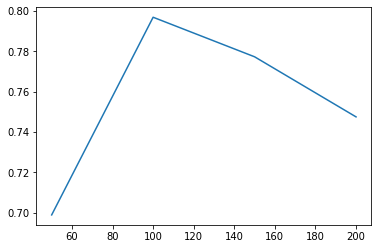

[ $$$ ] TEST


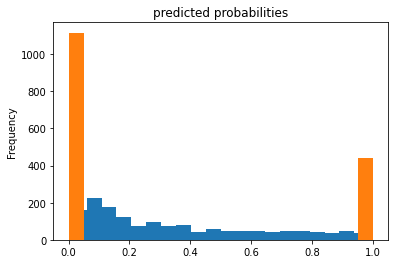

[ *** ] STEP MAX: 250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.816919
accuracy_baseline         0.539141
auc                       0.913814
auc_precision_recall      0.894760
average_loss              0.382091
label/mean                0.460859
loss                      0.605232
precision                 0.814286
prediction/mean           0.463634
recall                    0.780822
global_step             250.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 16; R ERR: 65 TOTAL ERR: 81 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8142985467261238
[ $ ] VALIDATION ACCURACY OVER TIME: 


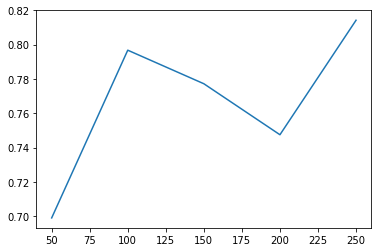

[ $$$ ] TEST


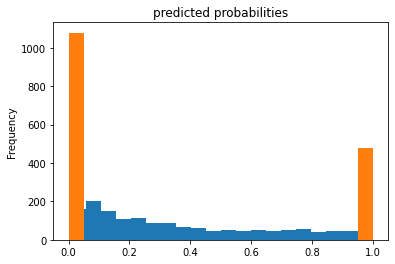

[ *** ] STEP MAX: 300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.808201
accuracy_baseline         0.576720
auc                       0.887077
auc_precision_recall      0.845677
average_loss              0.417693
label/mean                0.423280
loss                      0.631552
precision                 0.777778
prediction/mean           0.416380
recall                    0.765625
global_step             300.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 15; R ERR: 70 TOTAL ERR: 85 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8025372706422018
[ $ ] VALIDATION ACCURACY OVER TIME: 


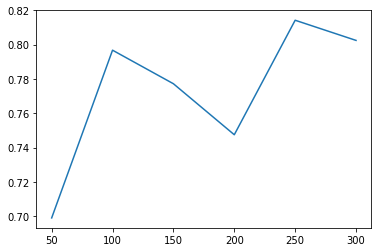

[ $$$ ] TEST


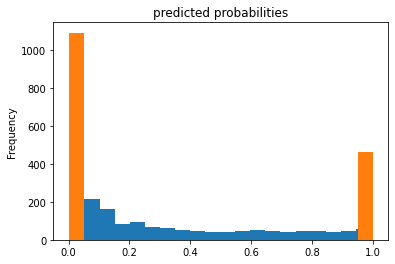

[ *** ] STEP MAX: 350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.780193
accuracy_baseline         0.504831
auc                       0.893832
auc_precision_recall      0.889945
average_loss              0.439340
label/mean                0.495169
loss                      0.727547
precision                 0.843373
prediction/mean           0.409566
recall                    0.682927
global_step             350.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 26; R ERR: 52 TOTAL ERR: 78 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.7792624576963474
[ $ ] VALIDATION ACCURACY OVER TIME: 


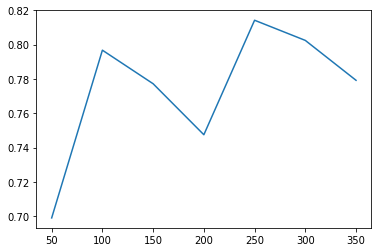

[ $$$ ] TEST


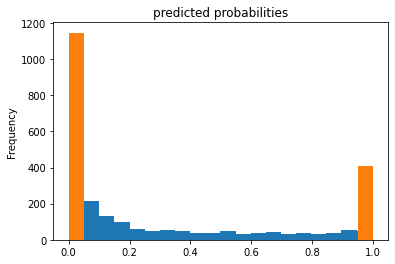

[ *** ] STEP MAX: 400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.827540
accuracy_baseline         0.585562
auc                       0.911677
auc_precision_recall      0.882609
average_loss              0.371752
label/mean                0.414439
loss                      0.556140
precision                 0.802676
prediction/mean           0.407834
recall                    0.774194
global_step             400.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 14; R ERR: 59 TOTAL ERR: 73 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8197451760200324
[ $ ] VALIDATION ACCURACY OVER TIME: 


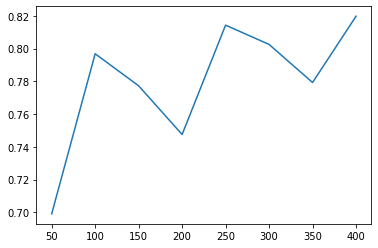

[ $$$ ] TEST


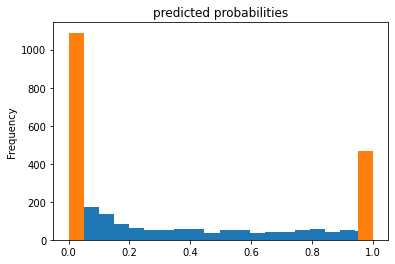

[ *** ] STEP MAX: 450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.817602
accuracy_baseline         0.547194
auc                       0.919925
auc_precision_recall      0.893822
average_loss              0.357588
label/mean                0.452806
loss                      0.560698
precision                 0.823171
prediction/mean           0.434948
recall                    0.760563
global_step             450.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 17; R ERR: 58 TOTAL ERR: 75 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8126826225417776
[ $ ] VALIDATION ACCURACY OVER TIME: 


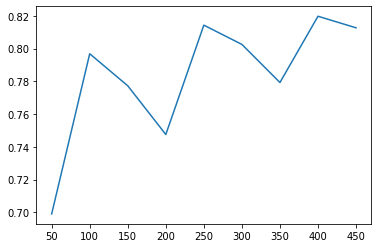

[ $$$ ] TEST


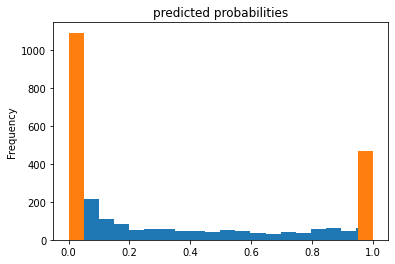

[ *** ] STEP MAX: 500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.829268
accuracy_baseline         0.512195
auc                       0.924315
auc_precision_recall      0.908614
average_loss              0.354925
label/mean                0.487805
loss                      0.582076
precision                 0.851351
prediction/mean           0.461943
recall                    0.787500
global_step             500.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 17; R ERR: 55 TOTAL ERR: 72 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8282738095238095
[ $ ] VALIDATION ACCURACY OVER TIME: 


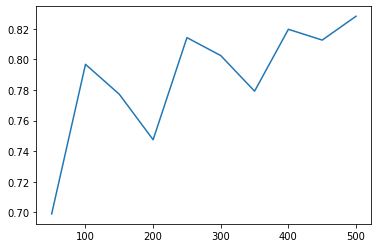

[ $$$ ] TEST


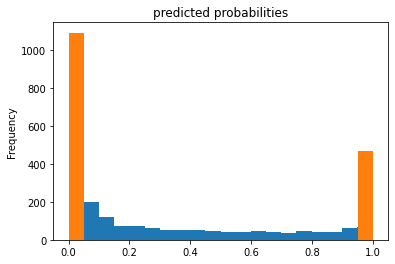

[ *** ] STEP MAX: 550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.817164
accuracy_baseline         0.527363
auc                       0.913620
auc_precision_recall      0.899914
average_loss              0.375543
label/mean                0.472637
loss                      0.603873
precision                 0.835735
prediction/mean           0.433938
recall                    0.763158
global_step             550.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 18; R ERR: 57 TOTAL ERR: 75 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8143619662363456
[ $ ] VALIDATION ACCURACY OVER TIME: 


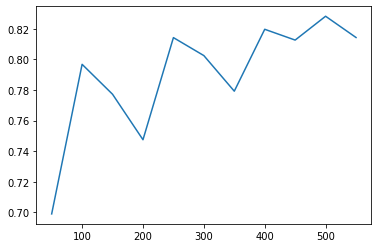

[ $$$ ] TEST


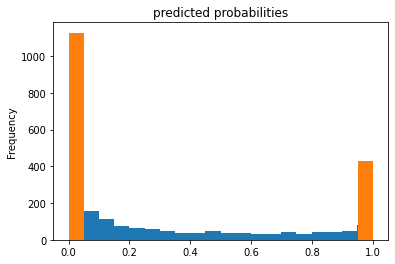

[ *** ] STEP MAX: 600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.853316
accuracy_baseline         0.547194
auc                       0.933402
auc_precision_recall      0.912250
average_loss              0.330462
label/mean                0.452806
loss                      0.518164
precision                 0.842857
prediction/mean           0.425959
recall                    0.830986
global_step             600.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 55 TOTAL ERR: 67 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8513903936439149
[ $ ] VALIDATION ACCURACY OVER TIME: 


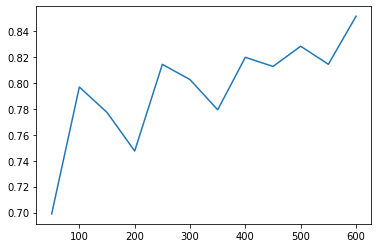

[ $$$ ] TEST


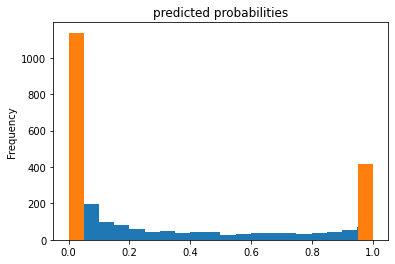

[ *** ] STEP MAX: 650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.817164
accuracy_baseline         0.527363
auc                       0.918492
auc_precision_recall      0.900004
average_loss              0.377615
label/mean                0.472637
loss                      0.607205
precision                 0.867508
prediction/mean           0.406553
recall                    0.723684
global_step             650.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 21; R ERR: 42 TOTAL ERR: 63 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8123138033763654
[ $ ] VALIDATION ACCURACY OVER TIME: 


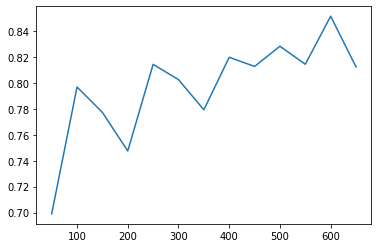

[ $$$ ] TEST


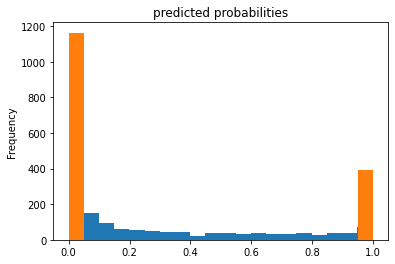

[ *** ] STEP MAX: 700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.827670
accuracy_baseline         0.508495
auc                       0.947538
auc_precision_recall      0.941199
average_loss              0.338020
label/mean                0.491505
loss                      0.557057
precision                 0.914827
prediction/mean           0.395823
recall                    0.716049
global_step             700.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 23; R ERR: 27 TOTAL ERR: 50 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8258051209522969
[ $ ] VALIDATION ACCURACY OVER TIME: 


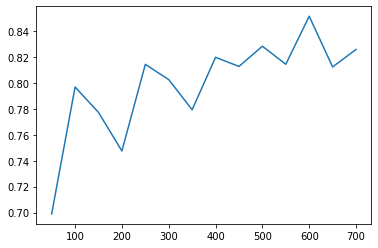

[ $$$ ] TEST


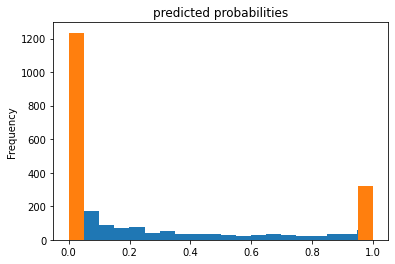

[ *** ] STEP MAX: 750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.858418
accuracy_baseline         0.547194
auc                       0.954381
auc_precision_recall      0.944144
average_loss              0.273333
label/mean                0.452806
loss                      0.428587
precision                 0.863095
prediction/mean           0.435296
recall                    0.816901
global_step             750.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 13; R ERR: 46 TOTAL ERR: 59 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8548376506122985
[ $ ] VALIDATION ACCURACY OVER TIME: 


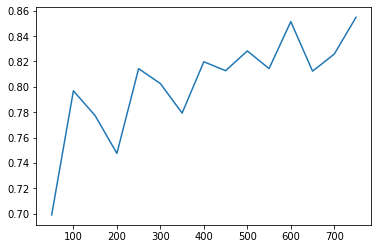

[ $$$ ] TEST


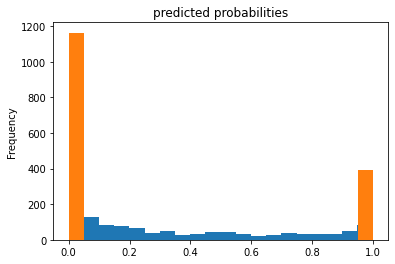

[ *** ] STEP MAX: 800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.840909
accuracy_baseline         0.539141
auc                       0.928251
auc_precision_recall      0.925856
average_loss              0.335580
label/mean                0.460859
loss                      0.531558
precision                 0.822102
prediction/mean           0.459774
recall                    0.835616
global_step             800.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 66 TOTAL ERR: 78 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8405248468127426
[ $ ] VALIDATION ACCURACY OVER TIME: 


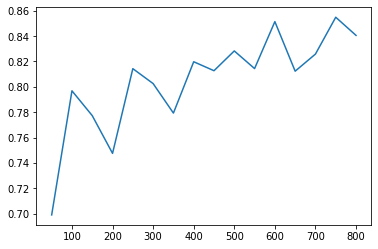

[ $$$ ] TEST


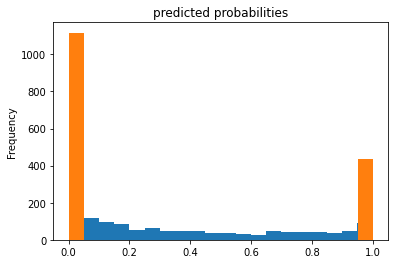

[ *** ] STEP MAX: 850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.853750
accuracy_baseline         0.531250
auc                       0.927075
auc_precision_recall      0.901057
average_loss              0.353583
label/mean                0.468750
loss                      0.565732
precision                 0.866477
prediction/mean           0.423700
recall                    0.813333
global_step             850.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 14; R ERR: 47 TOTAL ERR: 61 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8513725490196079
[ $ ] VALIDATION ACCURACY OVER TIME: 


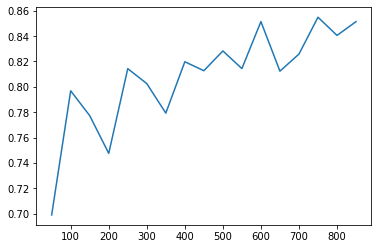

[ $$$ ] TEST


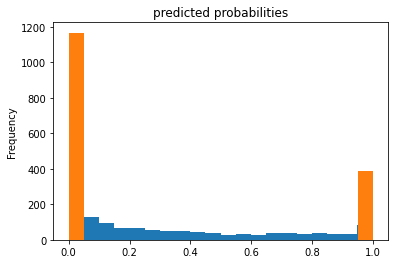

[ *** ] STEP MAX: 900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.858374
accuracy_baseline         0.519704
auc                       0.937614
auc_precision_recall      0.928215
average_loss              0.323671
label/mean                0.480296
loss                      0.525642
precision                 0.876712
prediction/mean           0.455559
recall                    0.820513
global_step             900.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 14; R ERR: 45 TOTAL ERR: 59 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8569388747113865
[ $ ] VALIDATION ACCURACY OVER TIME: 


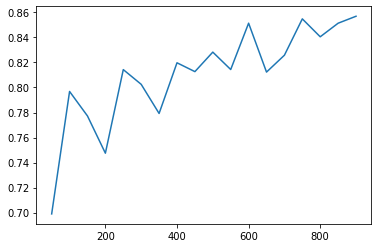

[ $$$ ] TEST


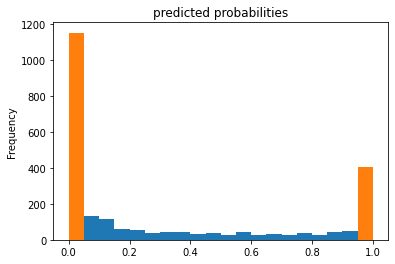

[ *** ] STEP MAX: 950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.866071
accuracy_baseline         0.547194
auc                       0.952493
auc_precision_recall      0.936939
average_loss              0.284754
label/mean                0.452806
loss                      0.446495
precision                 0.890625
prediction/mean           0.405096
recall                    0.802817
global_step             950.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 14; R ERR: 35 TOTAL ERR: 49 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8606159099116847
[ $ ] VALIDATION ACCURACY OVER TIME: 


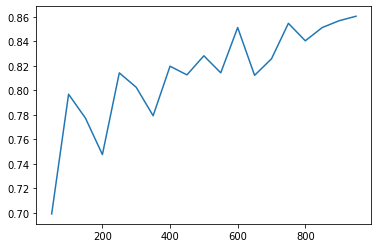

[ $$$ ] TEST


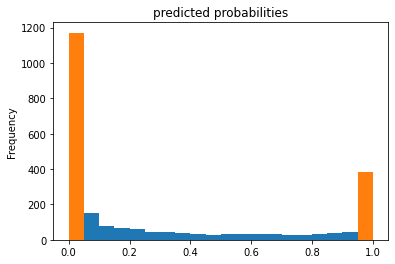

[ *** ] STEP MAX: 1000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.864103
accuracy_baseline          0.551282
auc                        0.955166
auc_precision_recall       0.945384
average_loss               0.267389
label/mean                 0.448718
loss                       0.417127
precision                  0.863095
prediction/mean            0.440918
recall                     0.828571
global_step             1000.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 46 TOTAL ERR: 58 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8607973421926911
[ $ ] VALIDATION ACCURACY OVER TIME: 


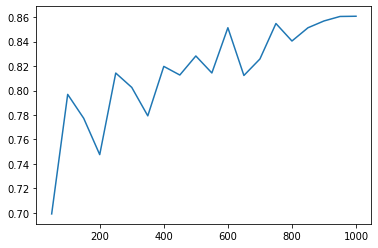

[ $$$ ] TEST


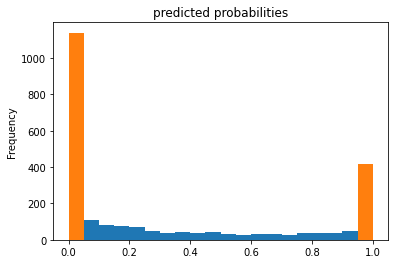

[ *** ] STEP MAX: 1050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.873698
accuracy_baseline          0.563802
auc                        0.937730
auc_precision_recall       0.909631
average_loss               0.313978
label/mean                 0.436198
loss                       0.482271
precision                  0.838068
prediction/mean            0.437335
recall                     0.880597
global_step             1050.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 8; R ERR: 57 TOTAL ERR: 65 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8744786460308158
[ $ ] VALIDATION ACCURACY OVER TIME: 


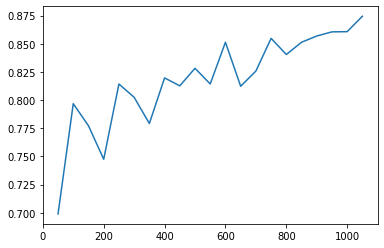

[ $$$ ] TEST


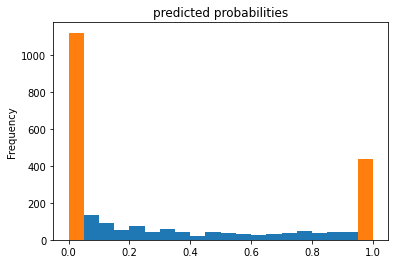

[ *** ] STEP MAX: 1100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.892857
accuracy_baseline          0.576720
auc                        0.967711
auc_precision_recall       0.955594
average_loss               0.236421
label/mean                 0.423280
loss                       0.357469
precision                  0.840456
prediction/mean            0.455086
recall                     0.921875
global_step             1100.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 5; R ERR: 56 TOTAL ERR: 61 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8967173165137615
[ $ ] VALIDATION ACCURACY OVER TIME: 


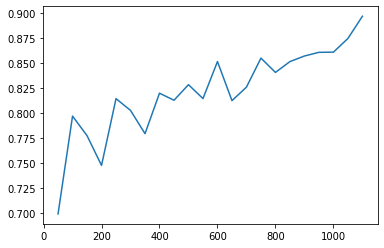

[ $$$ ] TEST


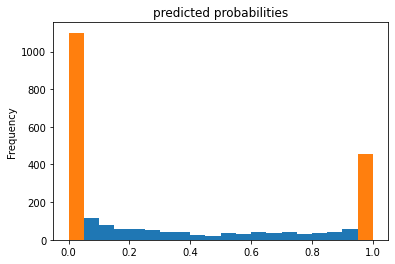

[ *** ] STEP MAX: 1150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.841146
accuracy_baseline          0.563802
auc                        0.925718
auc_precision_recall       0.900030
average_loss               0.351334
label/mean                 0.436198
loss                       0.539649
precision                  0.825688
prediction/mean            0.415717
recall                     0.805970
global_step             1150.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 13; R ERR: 57 TOTAL ERR: 70 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.837165213194995
[ $ ] VALIDATION ACCURACY OVER TIME: 


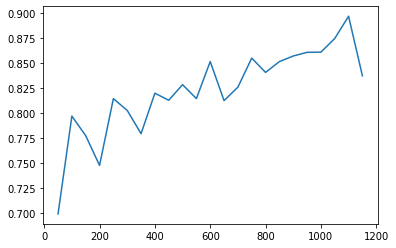

[ $$$ ] TEST


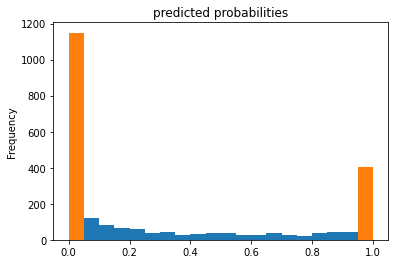

[ *** ] STEP MAX: 1200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.866337
accuracy_baseline          0.523515
auc                        0.950662
auc_precision_recall       0.936121
average_loss               0.284991
label/mean                 0.476485
loss                       0.460546
precision                  0.881543
prediction/mean            0.433897
recall                     0.831169
global_step             1200.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 13; R ERR: 43 TOTAL ERR: 56 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8647569924165669
[ $ ] VALIDATION ACCURACY OVER TIME: 


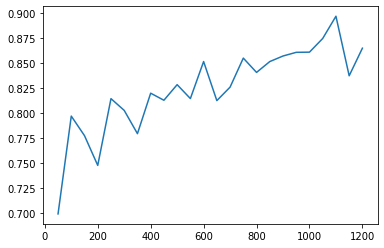

[ $$$ ] TEST


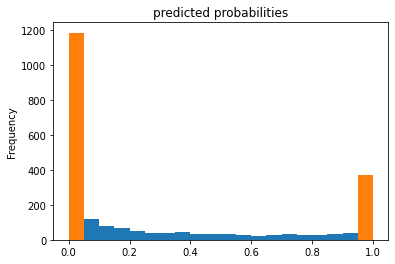

[ *** ] STEP MAX: 1250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.861842
accuracy_baseline          0.572368
auc                        0.946897
auc_precision_recall       0.910235
average_loss               0.291158
label/mean                 0.427632
loss                       0.442560
precision                  0.854839
prediction/mean            0.392834
recall                     0.815385
global_step             1250.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 45 TOTAL ERR: 57 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8559681697612733
[ $ ] VALIDATION ACCURACY OVER TIME: 


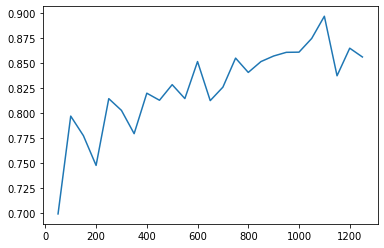

[ $$$ ] TEST


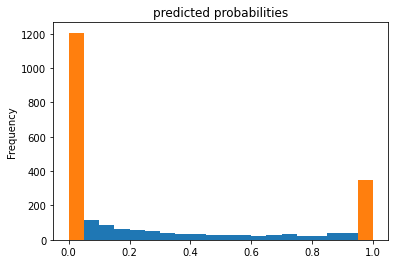

[ *** ] STEP MAX: 1300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.853316
accuracy_baseline          0.547194
auc                        0.940789
auc_precision_recall       0.930096
average_loss               0.312966
label/mean                 0.452806
loss                       0.490731
precision                  0.863636
prediction/mean            0.423885
recall                     0.802817
global_step             1300.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 14; R ERR: 45 TOTAL ERR: 59 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.848960898256673
[ $ ] VALIDATION ACCURACY OVER TIME: 


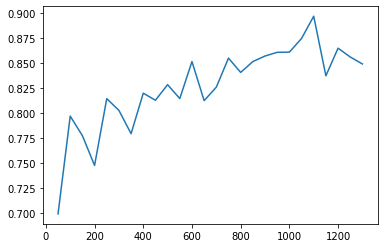

[ $$$ ] TEST


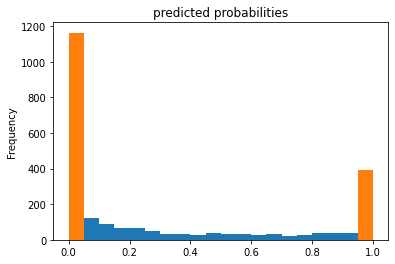

[ *** ] STEP MAX: 1350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.881010
accuracy_baseline          0.501202
auc                        0.959146
auc_precision_recall       0.953763
average_loss               0.260772
label/mean                 0.498798
loss                       0.433924
precision                  0.891089
prediction/mean            0.469105
recall                     0.867470
global_step             1350.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 11; R ERR: 44 TOTAL ERR: 55 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8809771459940481
[ $ ] VALIDATION ACCURACY OVER TIME: 


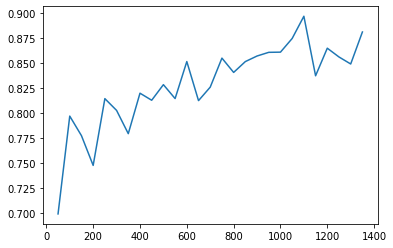

[ $$$ ] TEST


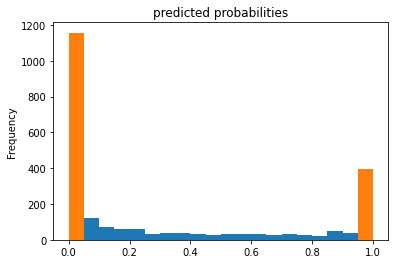

[ *** ] STEP MAX: 1400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.904639
accuracy_baseline          0.555412
auc                        0.957043
auc_precision_recall       0.931002
average_loss               0.259024
label/mean                 0.444588
loss                       0.402005
precision                  0.888252
prediction/mean            0.432611
recall                     0.898551
global_step             1400.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 7; R ERR: 39 TOTAL ERR: 46 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.9040317428292814
[ $ ] VALIDATION ACCURACY OVER TIME: 


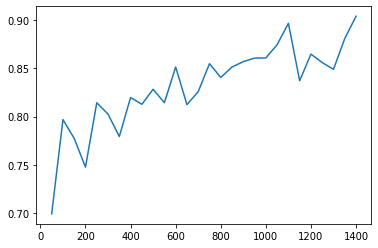

[ $$$ ] TEST


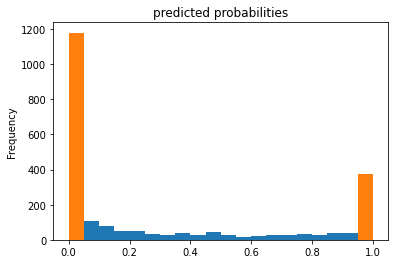

[ *** ] STEP MAX: 1450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.867801
accuracy_baseline          0.568063
auc                        0.940005
auc_precision_recall       0.911424
average_loss               0.320406
label/mean                 0.431937
loss                       0.489581
precision                  0.817174
prediction/mean            0.446094
recall                     0.893939
global_step             1450.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 7; R ERR: 66 TOTAL ERR: 73 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.87093283061025
[ $ ] VALIDATION ACCURACY OVER TIME: 


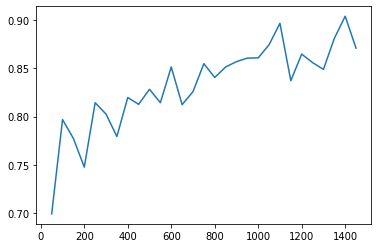

[ $$$ ] TEST


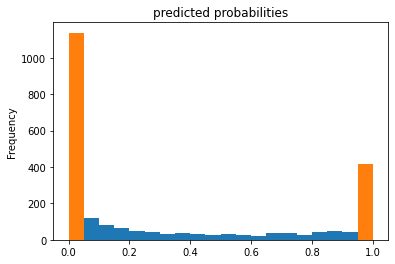

[ *** ] STEP MAX: 1500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.873775
accuracy_baseline          0.515931
auc                        0.944932
auc_precision_recall       0.937514
average_loss               0.306349
label/mean                 0.484069
loss                       0.499962
precision                  0.886243
prediction/mean            0.462811
recall                     0.848101
global_step             1500.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 43 TOTAL ERR: 55 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8729817493009412
[ $ ] VALIDATION ACCURACY OVER TIME: 


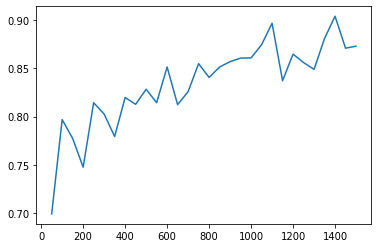

[ $$$ ] TEST


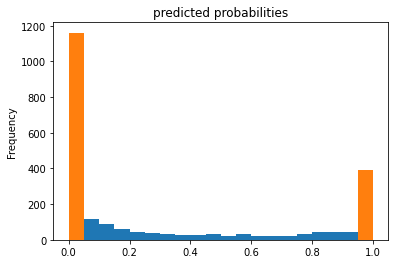

[ *** ] STEP MAX: 1550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.848485
accuracy_baseline          0.539141
auc                        0.944403
auc_precision_recall       0.928503
average_loss               0.313498
label/mean                 0.460859
loss                       0.496581
precision                  0.876923
prediction/mean            0.410346
recall                     0.780822
global_step             1550.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 16; R ERR: 40 TOTAL ERR: 56 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8435725514099645
[ $ ] VALIDATION ACCURACY OVER TIME: 


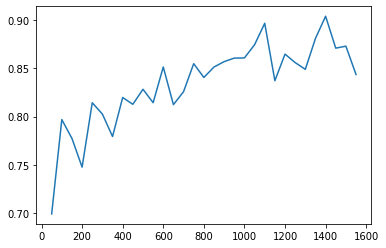

[ $$$ ] TEST


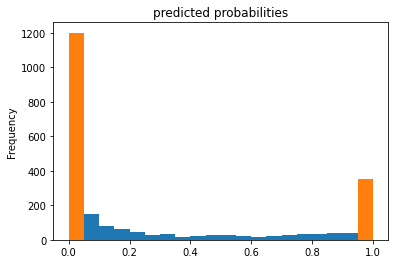

[ *** ] STEP MAX: 1600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.867949
accuracy_baseline          0.551282
auc                        0.954502
auc_precision_recall       0.941877
average_loss               0.268088
label/mean                 0.448718
loss                       0.418218
precision                  0.870871
prediction/mean            0.431169
recall                     0.828571
global_step             1600.000000
dtype: float64
[ $ ] VALIDATION ERROR STATS: 
D ERR: 12; R ERR: 43 TOTAL ERR: 55 on n = 500 labels
[ $ ] WEIGHTED ACCURACY ON VALIDATION: 
0.8642857142857142
[ $ ] VALIDATION ACCURACY OVER TIME: 


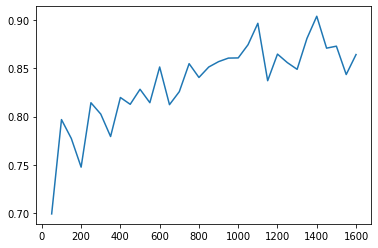

[ $$$ ] TEST


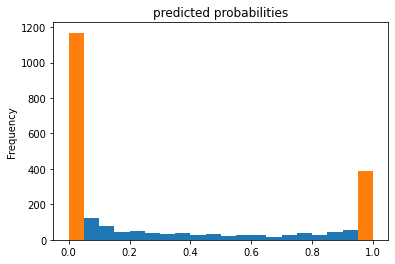

In [59]:
# Setup the feature columns for ingest into the model, given t
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))


# Initialize the model
est = tf.estimator.DNNLinearCombinedClassifier(
    linear_feature_columns=feature_columns,
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,  
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = 'Weight',
    dnn_dropout = None,
    batch_norm = False
)

# Setup variables that need to be initialized
n = 0
accs = []
ns = []

# MINI BATCH SETUP
batch_size = 500
indices = [x for x in range(1555)]

while True:
    incr = 50 # Number of steps to train on a given batch
    n += incr
    
    # EARLY STOPPING
    if n > 1600:
        break

    print(f"[ *** ] STEP MAX: {n}")

    # BATCH SELECTOR  
    batch_x, batch_y, valid_x, valid_y = generate_mini_batch(trimmed_data_frame, num_rows = batch_size)
    train_input_fn = make_input_fn(batch_x, batch_y, shuffle=True)
    eval_input_fn  = make_input_fn(valid_x, valid_y, shuffle=False, n_epochs=1)
    
    print("[ $$$ ] TRAINING")
    # Train up to n steps
    est.train(train_input_fn, max_steps=n)
    
    # Have the model predict on a validation set to estimate performance
    print("[ $$$ ] EVAL RESULTS:")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
    print(pd.Series(result))

    # Given the prediction dictionaries, process them into parseable form
    eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])
    eval_submission = cthresh(eval_preds, thresh = 0.5)
    
    # Calculate weighted accuracy, and error statistics on validation
    w_acc,d_err,r_err,total_err,n_lab = info_weighted_accuracy(eval_submission, valid_y)
    
    # Append to list of running weighted accuracies
    accs.append(w_acc)
        
    print("[ $ ] VALIDATION ERROR STATS: ")
    print(f"D ERR: {d_err}; R ERR: {r_err} TOTAL ERR: {total_err} on n = {n_lab} labels")

    print("[ $ ] WEIGHTED ACCURACY ON VALIDATION: ")
    print(w_acc)

    # Create a graph over time of validation accuracy
    print("[ $ ] VALIDATION ACCURACY OVER TIME: ")
    ns.append(n)
    plt.plot(ns,accs)
    plt.show()
    
    # Generate prediction on the test set
    print("[ $$$ ] TEST")
    pred_dicts = list(est.predict(test_input_fn))
    
    # Extract the prediction from model output
    preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    # Create histogram of the predictions
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    
    # Create a histogram of submission statistics
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    plt.show()
 
    # Package submission 
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>